In [ ]:
# DETECCIÓN DE FRAUDE FINANCIERO CON LOF E ISOLATION FOREST

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Cargar datasets

ruta_base = r"..\..\data\data"

application  = pd.read_csv(f"{ruta_base}\\application_train.csv")
credit       = pd.read_csv(f"{ruta_base}\\credit_card_balance.csv")
bureau       = pd.read_csv(f"{ruta_base}\\bureau.csv")
previous     = pd.read_csv(f"{ruta_base}\\previous_application.csv")
installments = pd.read_csv(f"{ruta_base}\\installments_payments.csv")

In [ ]:
# Preprocesamiento
credit_num = credit.select_dtypes(include=[np.number])
bureau_num = bureau.select_dtypes(include=[np.number])
previous_num = previous.select_dtypes(include=[np.number])
installments_num = installments.select_dtypes(include=[np.number])

credit_agg = credit_num.groupby("SK_ID_CURR", as_index=False).mean()
bureau_agg = bureau_num.groupby("SK_ID_CURR", as_index=False).mean()
previous_agg = previous_num.groupby("SK_ID_CURR", as_index=False).mean()
installments_agg = installments_num.groupby("SK_ID_CURR", as_index=False).mean()

# Unión de datasets
merged = (
    application
    .merge(credit_agg, on="SK_ID_CURR", how="left")
    .merge(bureau_agg, on="SK_ID_CURR", how="left")
    .merge(previous_agg, on="SK_ID_CURR", how="left")
    .merge(installments_agg, on="SK_ID_CURR", how="left")
)

print(f"Datos combinados: {merged.shape}")

Datos combinados: (307511, 183)


In [ ]:
# Crear indicadores financieros
den = merged["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
merged["RISK_INDEX"] = (
    (merged["AMT_PAYMENT_CURRENT"].fillna(0) + merged["AMT_DRAWINGS_CURRENT"].fillna(0))
    / den
).replace([np.inf, -np.inf], np.nan).fillna(0.0)

rng = merged["RISK_INDEX"].max() - merged["RISK_INDEX"].min()
merged["RISK_INDEX_NORMALIZED"] = (
    (merged["RISK_INDEX"] - merged["RISK_INDEX"].min()) / rng
)

if "AMT_CREDIT_SUM_DEBT" in merged.columns and "AMT_CREDIT_SUM" in merged.columns:
    merged["DEBT_RATIO"] = (
        merged["AMT_CREDIT_SUM_DEBT"] / merged["AMT_CREDIT_SUM"]
    ).replace([np.inf, -np.inf], np.nan).fillna(0.0)
else:
    merged["DEBT_RATIO"] = np.nan

# Selección de variables
variables = [
    "AMT_INCOME_TOTAL", "AMT_ANNUITY",
    "AMT_PAYMENT_CURRENT", "AMT_DRAWINGS_CURRENT",
    "AMT_CREDIT_LIMIT_ACTUAL", "RISK_INDEX_NORMALIZED", "DEBT_RATIO"
]

df = merged[variables].dropna().copy()

# Escalamiento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [ ]:
# Modelo LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.03)
y_pred_lof = lof.fit_predict(X_scaled)
lof_scores = -lof.negative_outlier_factor_

df["LOF_SCORE"] = lof_scores
df["OUTLIER_LOF"] = (y_pred_lof == -1).astype(int)

# Modelo Isolation Forest
isof = IsolationForest(contamination=0.03, n_estimators=200, random_state=42)
isof.fit(X_scaled)

df["IF_SCORE"] = -isof.score_samples(X_scaled)
df["OUTLIER_IF"] = isof.predict(X_scaled)
df["OUTLIER_IF"] = df["OUTLIER_IF"].replace({1: 0, -1: 1})

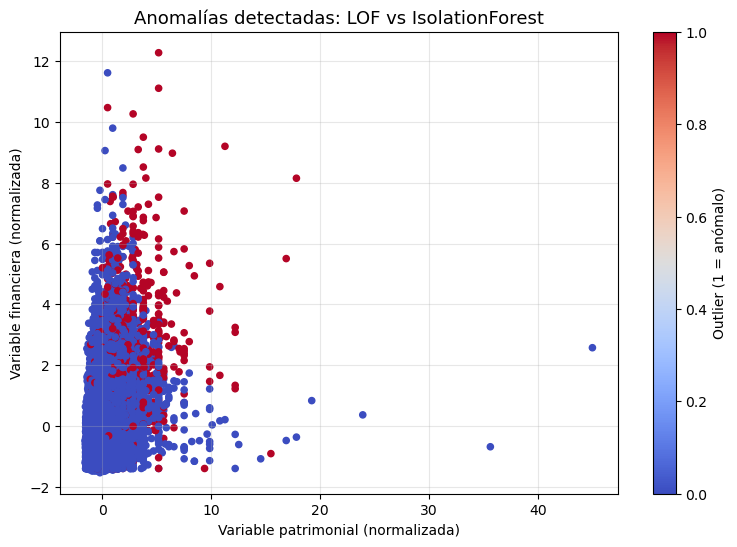

In [15]:
# Visualización
plt.figure(figsize=(9, 6))
plt.title("Anomalías detectadas: LOF vs IsolationForest", fontsize=13)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df["OUTLIER_IF"], cmap="coolwarm", s=20)
plt.xlabel("Variable patrimonial (normalizada)")
plt.ylabel("Variable financiera (normalizada)")
plt.colorbar(label="Outlier (1 = anómalo)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Ranking de clientes sospechosos
df["OUTLIER_TOTAL"] = df["OUTLIER_LOF"] + df["OUTLIER_IF"]
sospechosos = df[df["OUTLIER_TOTAL"] >= 2].sort_values(
    by=["LOF_SCORE", "IF_SCORE"], ascending=False
)

print(f"Clientes sospechosos detectados: {len(sospechosos)}")
print(sospechosos.head(10))

Clientes sospechosos detectados: 365
        AMT_INCOME_TOTAL  AMT_ANNUITY  AMT_PAYMENT_CURRENT  \
125751          112500.0   13320.2025         2.273811e+05   
107121          157500.0   10428.0900         4.500000e+04   
61333           236250.0   12469.4775         1.199100e+05   
15278           135000.0   22108.6050         8.550000e+05   
93411           157500.0    8927.0625         1.575000e+05   
67291           202500.0   12466.6800         1.125000e+06   
33485          1125000.0   65870.4600         5.564972e+03   
290687          225000.0   11250.0000         5.906720e+05   
189141          103500.0    6075.0000         3.975000e+04   
242926          450000.0   58349.3850         9.673797e+05   

        AMT_DRAWINGS_CURRENT  AMT_CREDIT_LIMIT_ACTUAL  RISK_INDEX_NORMALIZED  \
125751          7.984414e+04             25714.285714               1.000000   
107121          1.125000e+04              6750.000000               0.697487   
61333           4.419788e+03            